Loading training and testing datasets...
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4 

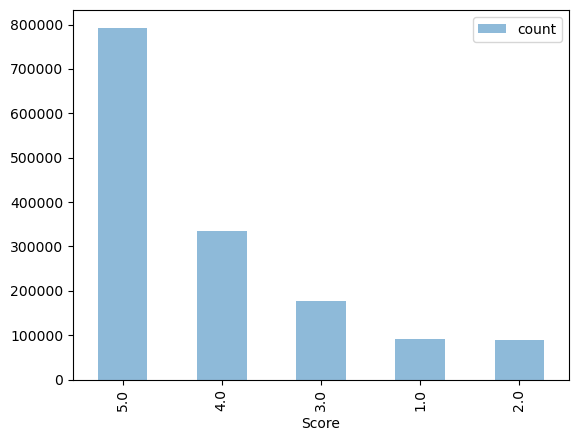

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START
Processing training set...
Extracting sentiment features...


100%|██████████████████████████████████████████████████████████████████████████████| 1697533/1697533 [07:33<00:00, 3739.57it/s]


Merging data for submission set...
Saving processed files...
Splitting training data into training and testing sets...
Training HistGradientBoostingClassifier...
Predicting on the test set...
Accuracy on testing set =  0.5647876855462438
Plotting confusion matrix...


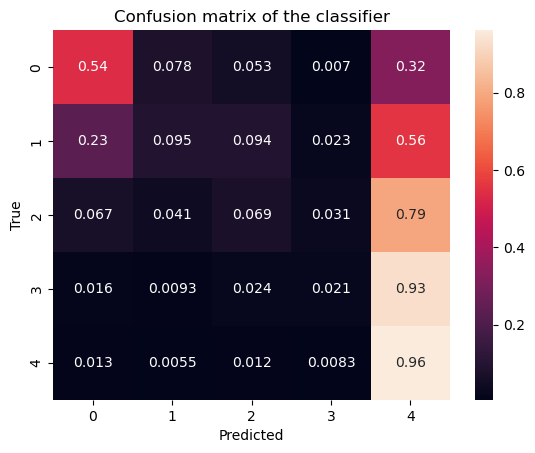

Creating submission file...
Process complete!


In [62]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from tqdm import tqdm
from textblob import TextBlob
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Enable tqdm pandas integration for progress tracking
tqdm.pandas()

# Load the CSV files with tqdm
print("Loading training and testing datasets...")
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Distribution of 'Score' in training data
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features
def add_features_to(df):
    # Feature extraction for Helpfulness
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Sentiment analysis using TextBlob with tqdm progress bar
    print("Extracting sentiment features...")
    df['Polarity'] = df['Text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Subjectivity'] = df['Text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    
    return df

# Load the feature extracted files if already generated
if exists('./data/X_train.csv'):
    print("Loading pre-processed training data...")
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    print("Loading pre-processed submission data...")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame with tqdm
    print("Processing training set...")
    train = add_features_to(trainingSet)
    
    # Merge for submission set
    print("Merging data for submission set...")
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    # Save processed data
    print("Saving processed files...")
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Split into training and testing sets
print("Splitting training data into training and testing sets...")
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'Polarity', 'Subjectivity']
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation with HistGradientBoostingClassifier
print("Training HistGradientBoostingClassifier...")
model = HistGradientBoostingClassifier(random_state=0).fit(X_train_select, Y_train)

# Predict the score using the model
print("Predicting on the test set...")
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
print("Plotting confusion matrix...")
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file
print("Creating submission file...")
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("Process complete!")


Loading training and testing datasets...
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4 

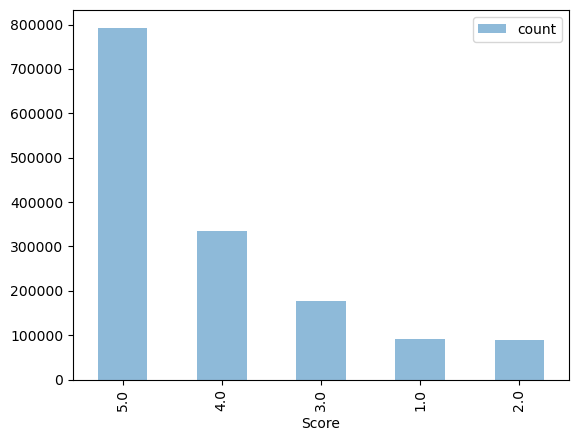

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START
Loading pre-processed training data...
Loading pre-processed submission data...
Splitting training data into training and testing sets...
Creating and training the voting ensemble model...


/Users/jonahgluck/miniconda3/envs/helixnano/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:55:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predicting on the test set...
Accuracy on testing set =  0.5647849925673784
Plotting confusion matrix...


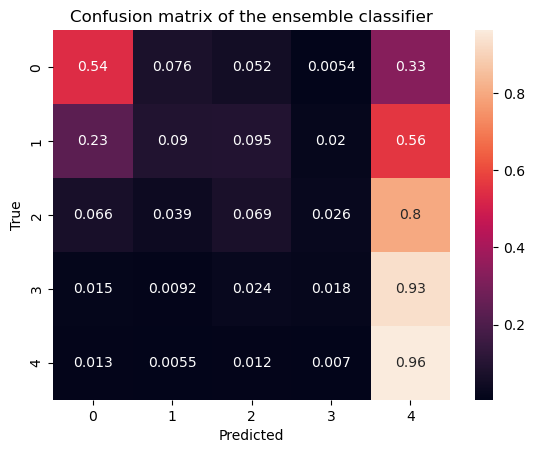

Creating submission file...
Process complete!


In [65]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from tqdm import tqdm
from textblob import TextBlob
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Enable tqdm pandas integration for progress tracking
tqdm.pandas()

# Load the CSV files with tqdm
print("Loading training and testing datasets...")
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Distribution of 'Score' in training data
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features
def add_features_to(df):
    # Feature extraction for Helpfulness
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Sentiment analysis using TextBlob with tqdm progress bar
    print("Extracting sentiment features...")
    df['Polarity'] = df['Text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['Subjectivity'] = df['Text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    
    return df

# Load the feature extracted files if already generated
if exists('./data/X_train.csv'):
    print("Loading pre-processed training data...")
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    print("Loading pre-processed submission data...")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame with tqdm
    print("Processing training set...")
    train = add_features_to(trainingSet)
    
    # Merge for submission set
    print("Merging data for submission set...")
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    # Save processed data
    print("Saving processed files...")
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Split into training and testing sets
print("Splitting training data into training and testing sets...")
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'Polarity', 'Subjectivity']
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Define individual models
hist_gb_model = HistGradientBoostingClassifier(random_state=0)
grad_boost_model = GradientBoostingClassifier(random_state=0)
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='mlogloss')

# Ensemble with VotingClassifier
print("Creating and training the voting ensemble model...")
ensemble_model = VotingClassifier(
    estimators=[
        ('hist_gb', hist_gb_model),
        ('grad_boost', grad_boost_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # 'soft' voting averages probabilities for better calibration
).fit(X_train_select, Y_train)

# Predict the score using the ensemble model
print("Predicting on the test set...")
Y_test_predictions = ensemble_model.predict(X_test_select)

# Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
print("Plotting confusion matrix...")
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the ensemble classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file
print("Creating submission file...")
X_submission['Score'] = ensemble_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("Process complete!")
